In [2]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [3]:
import numpy as np
import pandas as pd

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider

from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()

In [7]:
esios_spot = esios_provider.get_series(esios_tickers[-1], freq="H", start_index="2018-01-01 00:00", end_index="2018-01-14 23:59")
esios_demand = esios_provider.get_series(esios_tickers[1], freq="H", start_index="2018-01-01 00:00", end_index="2018-01-14 23:59")

In [2]:
forecaster = AutoARIMA(suppress_warnings=True)

y_train, y_test = temporal_train_test_split(esios_spot, test_size=24)
fh = np.arange(1, 25)

NameError: name 'esios_spot' is not defined

0.0929194997622998

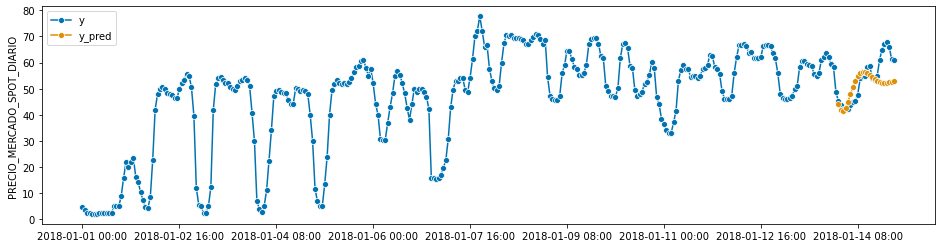

In [189]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh)
plot_series(esios_spot, y_pred, labels=["y", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

0.09276036951378497

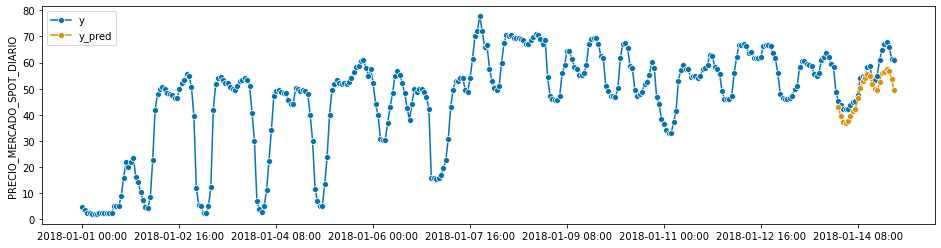

In [191]:
X = esios_demand
y_train, y_test, X_train, X_test = temporal_train_test_split(esios_spot, X, test_size=24)

forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)
plot_series(esios_spot, y_pred, labels=["y", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

In [28]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2023-01-01 00:00", end_index="2023-02-28 23:59")
esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]

forecasting_horizon = 24
fh = np.arange(1, forecasting_horizon+1)

forecaster = AutoARIMA(suppress_warnings=True)

0.19345105934656207

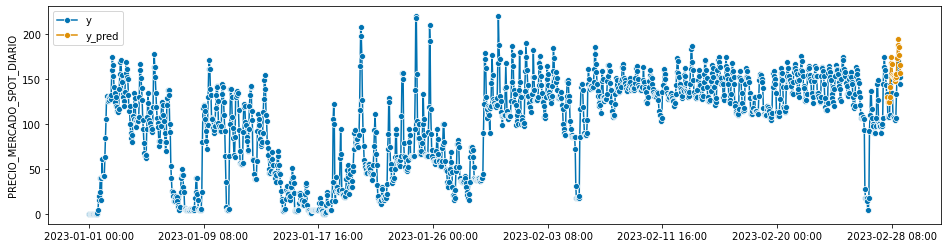

In [29]:
X = pd.concat([esios_spot.shift(24), esios_demand.shift(24)], axis=1)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=24)

forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)
plot_series(esios_spot, y_pred, labels=["y", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

In [30]:
train_window_size_list = [2, 5, 7, 14, 30]
train_window_size_list = [24*x for x in train_window_size_list]

X = pd.concat([esios_spot.shift(24), esios_demand.shift(24)], axis=1)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]

cv_results_list = []
for train_window_size in train_window_size_list:
    cv = SlidingWindowSplitter(window_length=train_window_size, fh=list(range(1,forecasting_horizon+1)), step_length=forecasting_horizon)
    # refit strategy makes a new model on each iteration, not an update
    cv_results = evaluate(forecaster, y=y, X=X, cv=cv, strategy="refit", return_data=True, error_score="raise")
    cv_results_list.append(cv_results)

/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in r

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


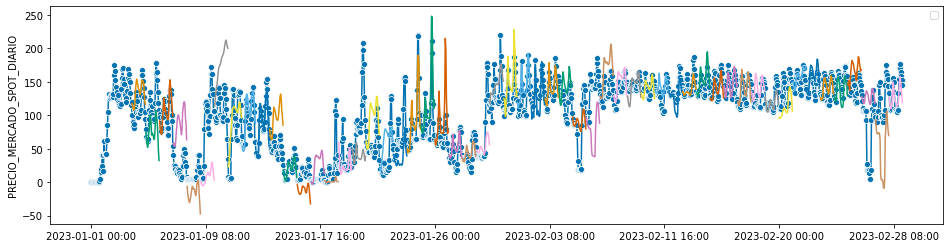

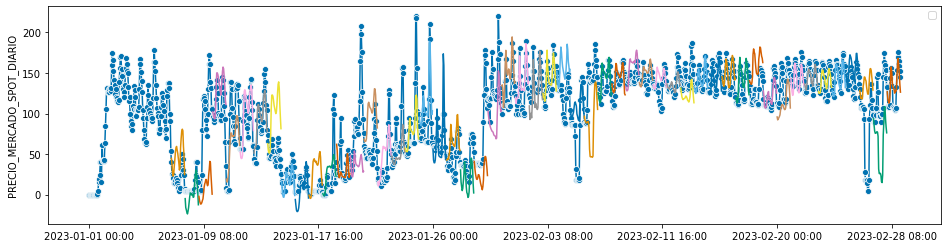

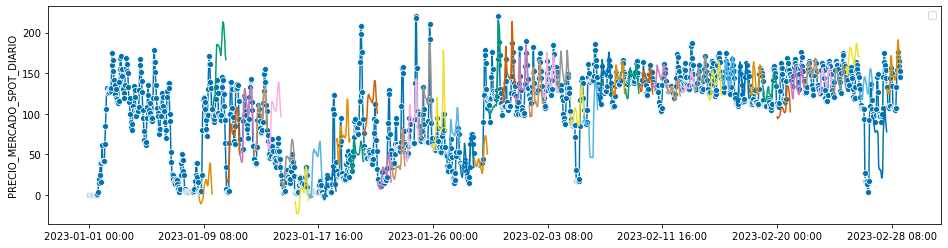

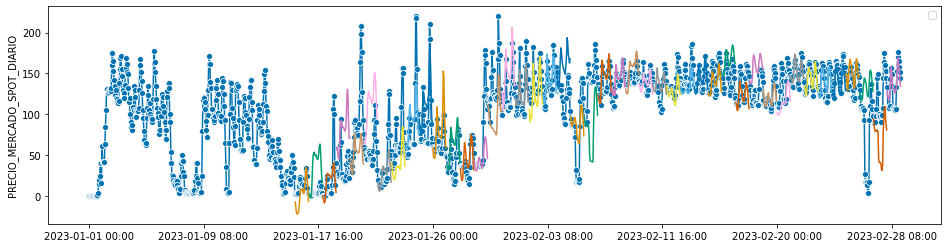

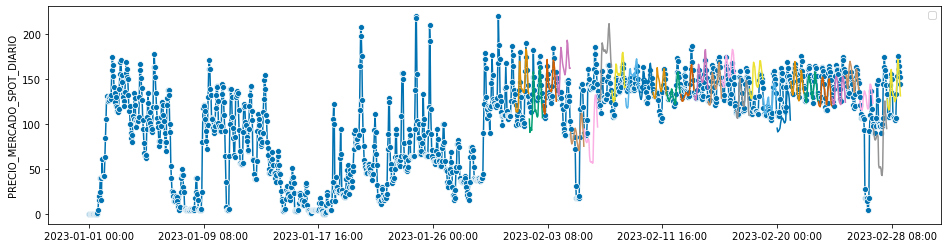

In [31]:
# visualization of a forecaster evaluation
for cv_results in cv_results_list:
    windows_nb = len(cv_results["y_pred"].tolist())

    fig, ax = plot_series(
        esios_spot,
        *cv_results["y_pred"].tolist(),
        markers=["o"]+["" for x in range(windows_nb)]
    )
    ax.legend()

In [32]:
cv_results_list[0]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.207640,2.705553,0.013762,48,2023-01-03 23:00,2023-01-02 00:00 42.17 2023-01-02 01:00 ...,2023-01-04 00:00 100.00 2023-01-04 01:00 ...,2023-01-04 00:00 117.206234 2023-01-04 01:0...
1,0.299563,0.815459,0.014388,48,2023-01-04 23:00,2023-01-03 00:00 120.00 2023-01-03 01:00 ...,2023-01-05 00:00 79.21 2023-01-05 01:00 ...,2023-01-05 00:00 75.417412 2023-01-05 01:0...
2,0.134413,1.523720,0.014937,48,2023-01-05 23:00,2023-01-04 00:00 100.00 2023-01-04 01:00 ...,2023-01-06 00:00 101.10 2023-01-06 01:00 ...,2023-01-06 00:00 91.283404 2023-01-06 01:0...
3,4.719592,0.919347,0.015026,48,2023-01-06 23:00,2023-01-05 00:00 79.21 2023-01-05 01:00 ...,2023-01-07 00:00 40.30 2023-01-07 01:00 ...,2023-01-07 00:00 56.081211 2023-01-07 01:0...
4,4.164299,0.662054,0.013899,48,2023-01-07 23:00,2023-01-06 00:00 101.10 2023-01-06 01:00 ...,2023-01-08 00:00 5.00 2023-01-08 01:00 ...,2023-01-08 00:00 -6.425753 2023-01-08 01:00...
5,1.095462,1.042882,0.015053,48,2023-01-08 23:00,2023-01-07 00:00 40.30 2023-01-07 01:00 ...,2023-01-09 00:00 4.20 2023-01-09 01:00 ...,2023-01-09 00:00 0.394437 2023-01-09 01:00...
6,0.832283,2.260910,0.013981,48,2023-01-09 23:00,2023-01-08 00:00 5.00 2023-01-08 01:00 ...,2023-01-10 00:00 96.79 2023-01-10 01:00 ...,2023-01-10 00:00 113.652655 2023-01-10 01:0...
7,2.014472,3.974372,0.013883,48,2023-01-10 23:00,2023-01-09 00:00 4.20 2023-01-09 01:00 ...,2023-01-11 00:00 8.00 2023-01-11 01:00 ...,2023-01-11 00:00 22.907217 2023-01-11 01:0...
8,0.195114,2.264821,0.014195,48,2023-01-11 23:00,2023-01-10 00:00 96.79 2023-01-10 01:00 ...,2023-01-12 00:00 56.60 2023-01-12 01:00 ...,2023-01-12 00:00 51.829576 2023-01-12 01:0...
9,0.106504,1.000185,0.014438,48,2023-01-12 23:00,2023-01-11 00:00 8.00 2023-01-11 01:00 ...,2023-01-13 00:00 44.20 2023-01-13 01:00 ...,2023-01-13 00:00 46.267513 2023-01-13 01:0...


In [33]:
cv_results_list[1]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,1.963274,0.922436,0.016407,120,2023-01-06 23:00,2023-01-02 00:00 42.17 2023-01-02 01:00 ...,2023-01-07 00:00 40.30 2023-01-07 01:00 ...,2023-01-07 00:00 44.774209 2023-01-07 01:00...
1,2.231706,0.919002,0.013142,120,2023-01-07 23:00,2023-01-03 00:00 120.00 2023-01-03 01:00 ...,2023-01-08 00:00 5.00 2023-01-08 01:00 ...,2023-01-08 00:00 -4.941107 2023-01-08 01:00...
2,1.303382,0.914370,0.013197,120,2023-01-08 23:00,2023-01-04 00:00 100.00 2023-01-04 01:00 ...,2023-01-09 00:00 4.20 2023-01-09 01:00 ...,2023-01-09 00:00 -2.090922 2023-01-09 01:00...
3,0.296724,4.532030,0.013152,120,2023-01-09 23:00,2023-01-05 00:00 79.21 2023-01-05 01:00 ...,2023-01-10 00:00 96.79 2023-01-10 01:00 ...,2023-01-10 00:00 102.001433 2023-01-10 01:0...
4,0.895615,4.687627,0.012948,120,2023-01-10 23:00,2023-01-06 00:00 101.10 2023-01-06 01:00 ...,2023-01-11 00:00 8.00 2023-01-11 01:00 ...,2023-01-11 00:00 19.106727 2023-01-11 01:00...
5,0.189165,3.375448,0.013348,120,2023-01-11 23:00,2023-01-07 00:00 40.30 2023-01-07 01:00 ...,2023-01-12 00:00 56.60 2023-01-12 01:00 ...,2023-01-12 00:00 52.306088 2023-01-12 01:0...
6,0.192482,4.615220,0.015058,120,2023-01-12 23:00,2023-01-08 00:00 5.00 2023-01-08 01:00 ...,2023-01-13 00:00 44.20 2023-01-13 01:00 ...,2023-01-13 00:00 51.353983 2023-01-13 01:0...
7,1.086677,1.766023,0.014290,120,2023-01-13 23:00,2023-01-09 00:00 4.20 2023-01-09 01:00 ...,2023-01-14 00:00 73.50 2023-01-14 01:00 ...,2023-01-14 00:00 62.839107 2023-01-14 01:0...
8,0.465143,1.312209,0.013168,120,2023-01-14 23:00,2023-01-10 00:00 96.79 2023-01-10 01:00 ...,2023-01-15 00:00 17.08 2023-01-15 01:00 ...,2023-01-15 00:00 16.534624 2023-01-15 01:00...
9,1.948791,0.842193,0.012967,120,2023-01-15 23:00,2023-01-11 00:00 8.00 2023-01-11 01:00 ...,2023-01-16 00:00 3.00 2023-01-16 01:00 ...,2023-01-16 00:00 -6.061796 2023-01-16 01:00...


In [34]:
train_window_size_list = [2, 5, 7, 14, 30]
train_window_size_list = [24*x for x in train_window_size_list]

X = esios_df.loc[:, esios_df.columns != "PRECIO_MERCADO_SPOT_DIARIO"]
X = X.shift(24)
X_na_rows = ~X.isna().any(axis=1)
X = X.dropna()

y = esios_spot[X_na_rows]

cv_results_list_all_predictors = []
for train_window_size in train_window_size_list:
    cv = SlidingWindowSplitter(window_length=train_window_size, fh=list(range(1,forecasting_horizon+1)), step_length=forecasting_horizon)
    # refit strategy makes a new model on each iteration, not an update
    cv_results = evaluate(forecaster, y=y, X=X, cv=cv, strategy="refit", return_data=True, error_score="raise")
    cv_results_list_all_predictors.append(cv_results)

/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in r

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


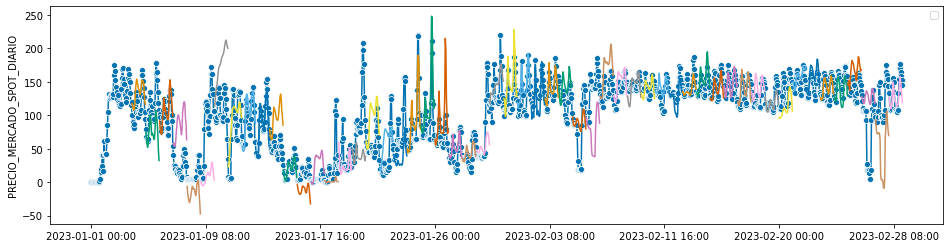

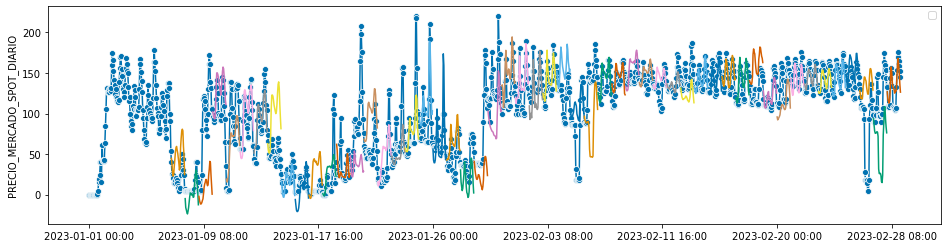

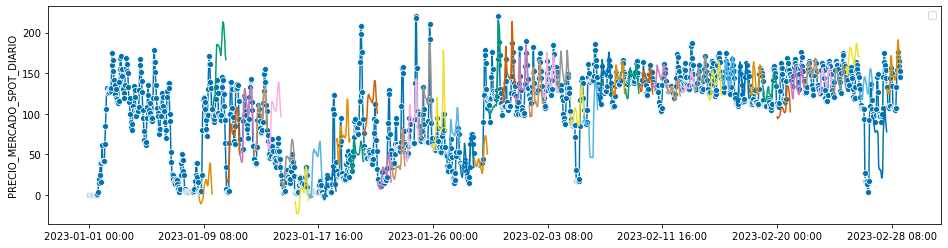

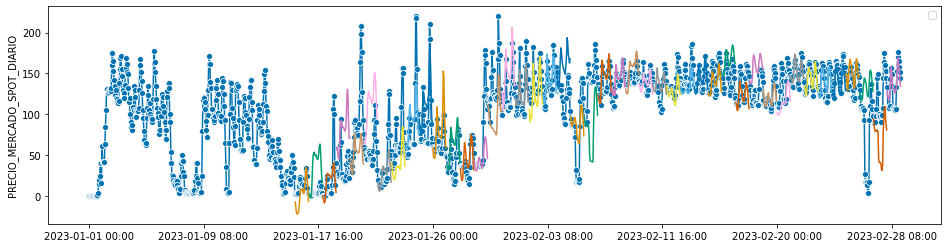

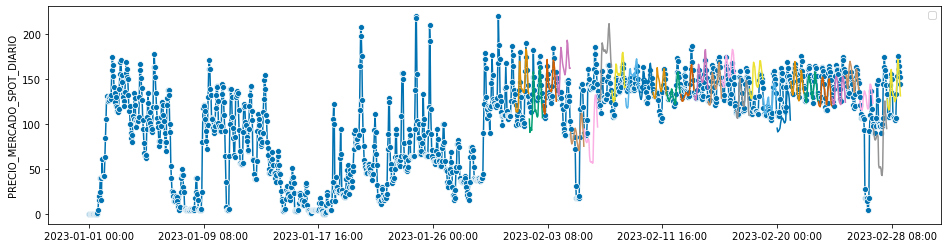

In [35]:
for cv_results in cv_results_list:
    windows_nb = len(cv_results["y_pred"].tolist())

    fig, ax = plot_series(
        esios_spot,
        *cv_results["y_pred"].tolist(),
        markers=["o"]+["" for x in range(windows_nb)]
    )
    ax.legend()